<a href="https://colab.research.google.com/github/AtSourav/Beta-VAE-on-MNIST/blob/main/MNIST_varying_beta_l12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


In [42]:
input_size = (28,28,1)
latent_dim = 24
batch_size = 64

# **Loading the dataset**

In [43]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [44]:
# we'll keep a train:valid split of 80:20, so we'll keep only 40k of the training images. this is to save some time training.

In [45]:
img_train = img_train[:40000]
print(img_train.shape)

(40000, 28, 28, 1)


# **Defining the model**

In [46]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(8, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(16, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(32, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(128)(x)
x = layers.ReLU()(x)

x = layers.Dense(64)(x)
x = layers.ReLU()(x)

x = layers.Dense(32)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 27, 27, 8) │         40 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 14, 14, 8) │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_69 (ReLU)     │ (None, 14, 14, 8) │          0 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 13, 13,    │        528 │ re_lu_69[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 6, 6, 16)  │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_70 (ReLU)     │ (None, 6, 6, 16)  │          0 │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 5, 5, 32)  │      2,080 │ re_lu_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_71 (ReLU)     │ (None, 5, 5, 32)  │          0 │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 4, 4, 32)  │      4,128 │ re_lu_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_72 (ReLU)     │ (None, 4, 4, 32)  │          0 │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 3, 3, 64)  │      8,256 │ re_lu_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_73 (ReLU)     │ (None, 3, 3, 64)  │          0 │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 2, 2, 128) │     32,896 │ re_lu_73[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_74 (ReLU)     │ (None, 2, 2, 128) │          0 │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 512)       │          0 │ re_lu_74[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │     65,664 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_75 (ReLU)     │ (None, 128)       │          0 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ re_lu_75[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_76 (ReLU)     │ (None, 64)        │          0 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 32)        │      2,080 │ re_lu_76[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_77 (ReLU)     │ (None, 32)        │          0 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 48)        │      1,584 │ re_lu_77[0][0]  

 Total params: 127,864 (499.47 KB)

 Trainable params: 127,864 (499.47 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(32)(x)
x = layers.ReLU()(x)

x = layers.Dense(64)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,64))(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(8, 2, strides=2, padding='same')(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_79 (ReLU)                 │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_80 (ReLU)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_81 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 2, 2, 32)       │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_82 (ReLU)                 │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 4, 4, 32)       │         4,128 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_83 (ReLU)                 │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 8, 8, 16)       │         2,064 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_84 (ReLU)                 │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 14, 14, 8)      │           520 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_85 (ReLU)                 │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 28, 28, 1)      │            33 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,849 (77.54 KB)

 Trainable params: 19,849 (77.54 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
decoder_out = decoder(encoder(encoder_input)[2])
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 24), (None,    │       127,864 │
│                                 │ 24), (None, 24)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │        19,849 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,713 (577.00 KB)

 Trainable params: 147,713 (577.00 KB)

 Non-trainable params: 0 (0.00 B)

## **beta**

In [49]:
beta=0.81

def vae_loss_1(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [50]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.993, staircase=True)
optim = keras.optimizers.Adam(learning_rate = lr_decay)
VAE.compile(optimizer=optim,loss=vae_loss_1)

In [51]:
epochs = 15
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=epochs, steps_per_epoch=None)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 304.8546 - val_loss: 194.2510
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 192.2292 - val_loss: 181.2804
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 178.4493 - val_loss: 169.4159
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 167.3200 - val_loss: 159.1049
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 157.3472 - val_loss: 152.9876
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 152.4697 - val_loss: 149.6501
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 149.1735 - val_loss: 147.1346
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 148.0226 - val_loss: 146.6273
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 146.0385 - val_loss: 145.2484
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 144.9600 - val_loss: 145.0287
Epoch 11/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 144.8676 - val_l

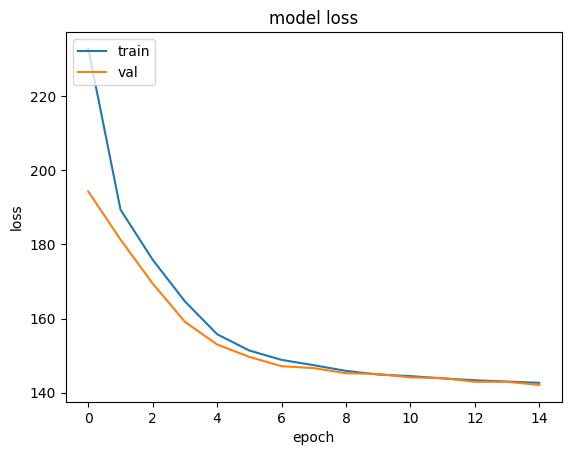

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
import math
def plot_reconstruction(set, name,seed_val, epochs, beta, size):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = size)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  _,_,z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  sze2 = int(math.ceil(size/20))
  print(sze2)
  digits_recon = plt.figure(figsize=(21,sze2))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
  digits_recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, beta='+str(beta)+', latent_dim = 12', fontweight= 'bold', y=1)

  digits_recon.tight_layout()

  for i in range(size + sze2):
    digits_recon.add_subplot(sze2,21,i+1)
    j = int(np.floor(i/21))
    if (i%21) <10:
      img = set[tg_indices[j*10 + (i%21)]]
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    elif (i%21)==10:
      img = np.ones((14,14,1))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
    else:
      img = img_recon[j*10 + (i%21) - 11]
      plt.imshow(img, cmap='gray')
      plt.axis('off')

In [54]:
np.random.randint(0,img_train.shape[0],size = 100)

array([36870, 22390, 27335, 37696, 26990, 18095,  4294, 38478, 35284,
       12084, 34797,  8946,  8033,  9154, 28735, 19607,  1109, 33705,
       13218, 26397, 17055, 21411, 25248, 34804, 26604, 15695, 23179,
        3271, 31793, 25844,  1681, 10975,  2598, 11887, 27168, 30584,
       31136, 30915, 25902, 27053, 21634,  5116, 33779, 24246,  4217,
       31604, 17578, 34044, 13300, 18795, 28471,  7230, 34721,  4078,
       29672, 39228, 30312, 32488, 11558, 15393, 23450,  1816, 38219,
        5484, 16404,  2918, 39583, 34291, 12595,  8083, 27250, 16146,
       36125, 33647, 17224,  7422,  4564, 34540,  3696, 17533, 22786,
       12841, 37178, 32079,   634,    43,  2689, 17001, 11858, 18862,
       20730,  2826, 33181, 25283,  1314, 20028, 14956,  2294, 30796,
       37631])

2


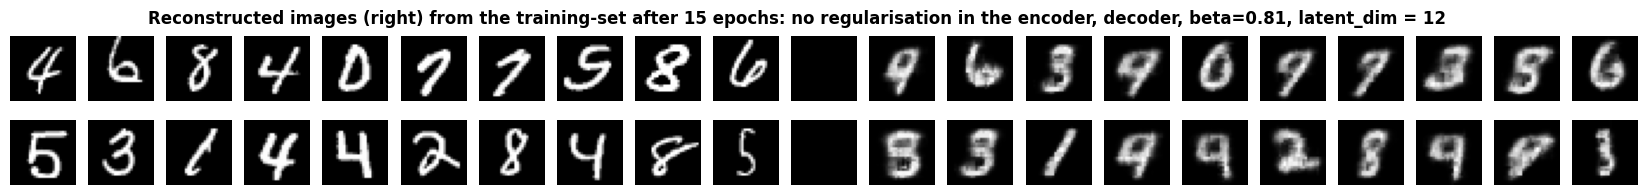

In [55]:
plot_reconstruction(img_train,'training',200,epochs,beta, 40)

2


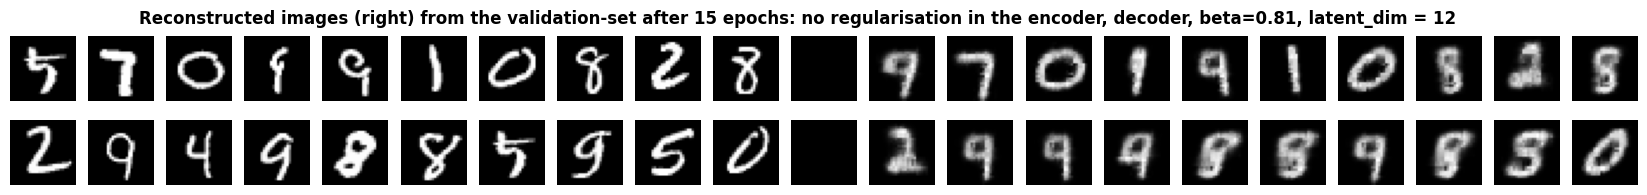

In [56]:
plot_reconstruction(img_valid,'validation',500,epochs,beta, 40)

In [57]:
def plot_generated(scale,edge, seed_val, epochs, beta):   # edge is the length of the square grid we want to create
  np.random.seed(seed_val)
  z_rand = tf.convert_to_tensor(-scale + 2*scale*np.random.random((edge**2,latent_dim)))

  img_rand = decoder(z_rand)

  digits_rand = plt.figure(figsize=(edge,edge))
  digits_rand.suptitle('Some randomly generated images (after '+ str(epochs) + ' epochs of training): no regularisation in the encoder, decoder, beta='+str(beta)+', latent_dim = 12', fontweight= 'bold', y=0.93)


  for i in range(edge**2):
    digits_rand.add_subplot(edge,edge,i+1)
    img = img_rand[i]
    plt.imshow(img, cmap='gray')
    plt.axis('off')



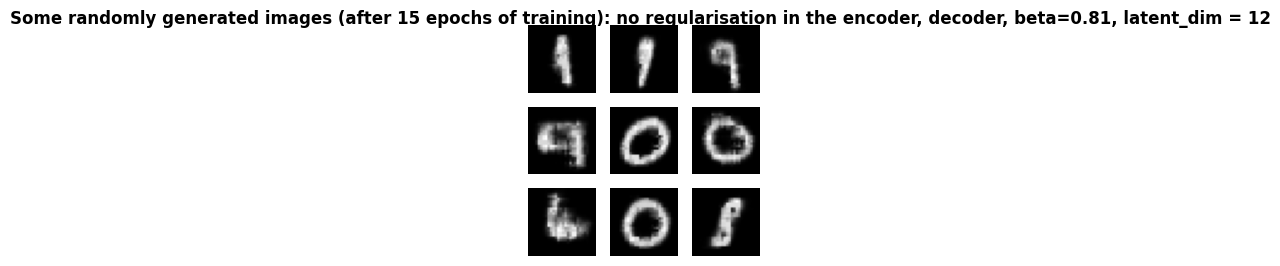

In [58]:
plot_generated(2,3,111,epochs, beta)

From an inspection of the images, it seems like the training set images are indeed reconstructed slightly better than the validation set images. This is understandable as the loss plots seems to indicate that the performance is very slightly better on the training set than on the validation set.   

We shall take this to further extremes by taking a low value of beta which should suppress the kl div term w.r.t. the reconstruction term.

The improvement from beta=1 to beta=3 (the model with the latter should be equally well-trained if not a little better than the previous) seems to be that the quality is more averaged out and uniform, especially for the generated images. The generated images are a little smoother but also more blurry (which is expected I guess).